<a href="https://colab.research.google.com/github/Gilf641/EVA4/blob/master/S11/S11_Assignment.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

**Mount your G-Drive**

In [1]:
from __future__ import print_function
%matplotlib inline

from google.colab import drive
drive.mount('/content/drive', force_remount=True)

Mounted at /content/drive


**Add Library Path in your def search path**

In [2]:
import sys
sys.path.append('/content/drive/My Drive/EVA4/updLib2/evaLibrary')
!ls '/content/drive/My Drive/EVA4/updLib2/evaLibrary'

AlbTestTransforms.py   customNet.py    execute.py    resNet.py
AlbTrainTransforms.py  cyclicLR.py     Gradcam.py    rohan_library.py
albumentations.py      DataLoaders.py  LR_Finder.py
all.py		       displayData.py  __pycache__


In [3]:
# !pip install torch-lr-finder -v --global-option="amp"

**Import required libraries**

In [4]:
from rohan_library import *
import execute
from resNet import ResNet18
import displayData as display
import Gradcam as gdc
import albumentations as alb
import DataLoaders as loader
import AlbTestTransforms
import AlbTrainTransforms
import LR_Finder as lrf
import cyclicLR as clr
import customNet

  pip install torch-lr-finder -v --global-option="amp"


**Albumentations**

In [5]:
albTrain = AlbTrainTransforms.train_transforms()
albTest = AlbTestTransforms.test_transforms()

**Load the Datasets**

In [6]:
train = torchvision.datasets.CIFAR10(root = './data', train = True, download = True, transform = albTrain)
test = torchvision.datasets.CIFAR10(root = './data', train = False, download = True, transform = albTest)
classes = ('plane', 'car', 'bird', 'cat', 'deer', 'dog', 'frog', 'horse', 'ship', 'truck')

Files already downloaded and verified
Files already downloaded and verified


**DataLoader for Train & Test Dataset**

In [7]:
dl = loader.DataLoaders(batch_size=512)
trainLoader = dl.dataLoader(train)
testLoader = dl.dataLoader(test)


In [8]:
dataiter = iter(trainLoader)

images, labels = dataiter.next()
print(images.shape)
print(labels.shape)

torch.Size([512, 3, 32, 32])
torch.Size([512])


**Displaying Random Images**

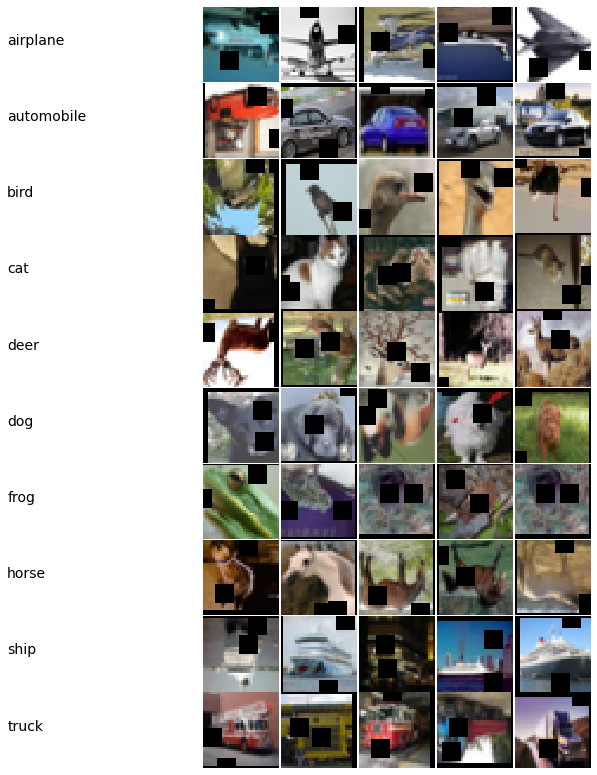

In [9]:
display.class_images(trainLoader)


**CustomNet**

In [10]:
from torchsummary import summary
use_cuda = torch.cuda.is_available()
device = torch.device('cuda' if use_cuda else 'cpu')
print('Device set to ', device)

model = customNet.main11().to(device)
summary(model, input_size=(3,32,32))

Device set to  cuda
----------------------------------------------------------------
        Layer (type)               Output Shape         Param #
            Conv2d-1           [-1, 64, 32, 32]           1,792
       BatchNorm2d-2           [-1, 64, 32, 32]             128
              ReLU-3           [-1, 64, 32, 32]               0
            Conv2d-4          [-1, 128, 32, 32]          73,856
         MaxPool2d-5          [-1, 128, 16, 16]               0
       BatchNorm2d-6          [-1, 128, 16, 16]             256
              ReLU-7          [-1, 128, 16, 16]               0
            Conv2d-8          [-1, 128, 16, 16]         147,456
       BatchNorm2d-9          [-1, 128, 16, 16]             256
           Conv2d-10          [-1, 128, 16, 16]         147,456
      BatchNorm2d-11          [-1, 128, 16, 16]             256
       BasicBlock-12          [-1, 128, 16, 16]               0
           Conv2d-13          [-1, 256, 16, 16]         295,168
        MaxPool2d-1

/content/drive/My Drive/EVA4/updLib2/evaLibrary/customNet.py:122: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outX)


**LR Finder**

In [11]:
# criterion = execute.cross_entropy_loss()
criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr=1e-7, weight_decay=1e-2)
lr_finder = lrf.LRFinder(model, optimizer, criterion, device="cuda")
lr_finder.range_test(trainLoader, end_lr=100, num_iter=100, step_mode="exp")

/content/drive/My Drive/EVA4/updLib2/evaLibrary/customNet.py:122: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outX)


The loss has diverged, Stopping Early!


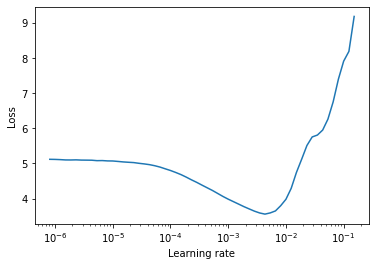

In [12]:
lr_finder.plot()

In [13]:
lr_finder.reset()

**Cyclic Learning Rate Range Test**

/content/drive/My Drive/EVA4/updLib2/evaLibrary/customNet.py:122: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outX)


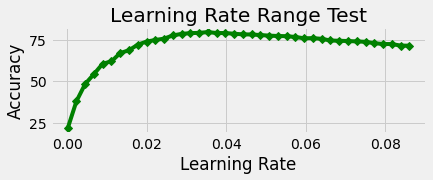

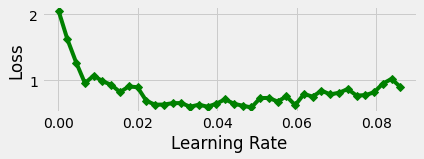

In [14]:
clr.lr_rangetest(device, model, trainLoader, criterion, 0.0001, 0.001, 40)

**Cyclic LR Plot**

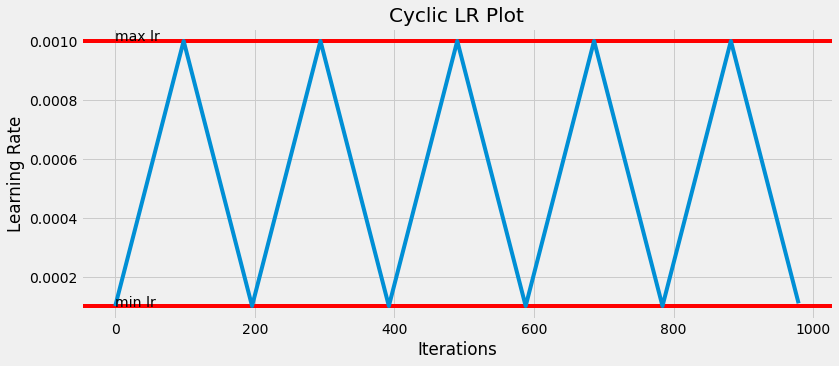

In [15]:
clr1 = clr.CyclicLR(0.001, 0.0001, len(trainLoader), len(trainLoader)*10)
clr1.cyclic_lr(plotGraph=True)

**Modelling**

In [16]:
incorrectSamples = []
correctSamples = []
correctLabels = []
learningRates = []
model = customNet.main11().to(device)
EPOCHS = 24

criterion = nn.NLLLoss()
optimizer = optim.SGD(model.parameters(), lr = 0.01, momentum=0.95, weight_decay = 1e-2, nesterov = True) 
scheduler = torch.optim.lr_scheduler.OneCycleLR(optimizer, max_lr = 0.03, total_steps=2400, epochs = 24, steps_per_epoch=len(trainLoader),
                                                pct_start=5/EPOCHS, anneal_strategy='linear', cycle_momentum=True, 
                                                base_momentum=0.85, max_momentum=0.95, div_factor=32, final_div_factor=1)



model1 = execute.Test_Train(model, device, optimizer, scheduler, criterion)



for epoch in range(1, EPOCHS+1):
  print('EPOCH: ',epoch)
  model1.train(trainLoader, epoch, L1lambda=1e-5)
  scheduler.step()
  model1.test(testLoader, 'model1.pt', correctSamples, correctLabels, incorrectSamples)
  for param_group in optimizer.param_groups:
    print('Learning Rate = {a} for EPOCH {e}'.format(a = round(param_group['lr'],5), e=epoch+1))
    learningRates.append(param_group['lr'])

  0%|          | 0/98 [00:00<?, ?it/s]

EPOCH:  1


/content/drive/My Drive/EVA4/updLib2/evaLibrary/customNet.py:122: UserWarning: Implicit dimension choice for log_softmax has been deprecated. Change the call to include dim=X as an argument.
  return F.log_softmax(outX)
Loss=2.230734348297119 Batch_id=97 Accuracy=33.14: 100%|██████████| 98/98 [00:28<00:00,  3.46it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (inf --> 1.8357).  Saving model ...

Test set: Average loss: 1.8357, Accuracy: 3509/10000 (35.09%)

Learning Rate = 0.0067 for EPOCH 2
EPOCH:  2


Loss=1.7301090955734253 Batch_id=97 Accuracy=48.63: 100%|██████████| 98/98 [00:28<00:00,  3.42it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (1.8357 --> 1.4800).  Saving model ...

Test set: Average loss: 1.4800, Accuracy: 5303/10000 (53.03%)

Learning Rate = 0.01247 for EPOCH 3
EPOCH:  3


Loss=1.497711420059204 Batch_id=97 Accuracy=57.04: 100%|██████████| 98/98 [00:28<00:00,  3.46it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (1.4800 --> 1.2661).  Saving model ...

Test set: Average loss: 1.2661, Accuracy: 5862/10000 (58.62%)

Learning Rate = 0.01824 for EPOCH 4
EPOCH:  4


Loss=1.2724199295043945 Batch_id=97 Accuracy=62.57: 100%|██████████| 98/98 [00:28<00:00,  3.45it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (1.2661 --> 0.9962).  Saving model ...

Test set: Average loss: 0.9962, Accuracy: 6588/10000 (65.88%)

Learning Rate = 0.024 for EPOCH 5
EPOCH:  5


Loss=1.097005009651184 Batch_id=97 Accuracy=66.95: 100%|██████████| 98/98 [00:28<00:00,  3.45it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.9962 --> 0.7565).  Saving model ...

Test set: Average loss: 0.7565, Accuracy: 7020/10000 (70.20%)

Learning Rate = 0.02977 for EPOCH 6
EPOCH:  6


Loss=0.9276018738746643 Batch_id=97 Accuracy=71.06: 100%|██████████| 98/98 [00:28<00:00,  3.43it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.9677, Accuracy: 6825/10000 (68.25%)

Learning Rate = 0.02855 for EPOCH 7
EPOCH:  7


Loss=0.8574076890945435 Batch_id=97 Accuracy=74.85: 100%|██████████| 98/98 [00:28<00:00,  3.46it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.8072, Accuracy: 7136/10000 (71.36%)

Learning Rate = 0.02703 for EPOCH 8
EPOCH:  8


Loss=0.8377108573913574 Batch_id=97 Accuracy=77.05: 100%|██████████| 98/98 [00:28<00:00,  3.48it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.7565 --> 0.6437).  Saving model ...

Test set: Average loss: 0.6437, Accuracy: 7762/10000 (77.62%)

Learning Rate = 0.02552 for EPOCH 9
EPOCH:  9


Loss=0.7861685156822205 Batch_id=97 Accuracy=79.68: 100%|██████████| 98/98 [00:28<00:00,  3.43it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.6437 --> 0.6434).  Saving model ...

Test set: Average loss: 0.6434, Accuracy: 7844/10000 (78.44%)

Learning Rate = 0.024 for EPOCH 10
EPOCH:  10


Loss=0.6487981081008911 Batch_id=97 Accuracy=81.10: 100%|██████████| 98/98 [00:28<00:00,  3.47it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.6434 --> 0.5932).  Saving model ...

Test set: Average loss: 0.5932, Accuracy: 7871/10000 (78.71%)

Learning Rate = 0.02249 for EPOCH 11
EPOCH:  11


Loss=0.7653101682662964 Batch_id=97 Accuracy=82.20: 100%|██████████| 98/98 [00:28<00:00,  3.45it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.5932 --> 0.5359).  Saving model ...

Test set: Average loss: 0.5359, Accuracy: 7749/10000 (77.49%)

Learning Rate = 0.02098 for EPOCH 12
EPOCH:  12


Loss=0.6011149883270264 Batch_id=97 Accuracy=82.97: 100%|██████████| 98/98 [00:28<00:00,  3.44it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5545, Accuracy: 8405/10000 (84.05%)

Learning Rate = 0.01946 for EPOCH 13
EPOCH:  13


Loss=0.6062943935394287 Batch_id=97 Accuracy=83.99: 100%|██████████| 98/98 [00:28<00:00,  3.43it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6187, Accuracy: 7798/10000 (77.98%)

Learning Rate = 0.01795 for EPOCH 14
EPOCH:  14


Loss=0.5982224345207214 Batch_id=97 Accuracy=84.43: 100%|██████████| 98/98 [00:28<00:00,  3.44it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6580, Accuracy: 7837/10000 (78.37%)

Learning Rate = 0.01643 for EPOCH 15
EPOCH:  15


Loss=0.4608079195022583 Batch_id=97 Accuracy=84.97: 100%|██████████| 98/98 [00:28<00:00,  3.45it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.5359 --> 0.4861).  Saving model ...

Test set: Average loss: 0.4861, Accuracy: 8297/10000 (82.97%)

Learning Rate = 0.01492 for EPOCH 16
EPOCH:  16


Loss=0.5094835758209229 Batch_id=97 Accuracy=85.69: 100%|██████████| 98/98 [00:28<00:00,  3.45it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5688, Accuracy: 8192/10000 (81.92%)

Learning Rate = 0.0134 for EPOCH 17
EPOCH:  17


Loss=0.5309951901435852 Batch_id=97 Accuracy=85.99: 100%|██████████| 98/98 [00:28<00:00,  3.45it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5060, Accuracy: 8450/10000 (84.50%)

Learning Rate = 0.01189 for EPOCH 18
EPOCH:  18


Loss=0.6065254807472229 Batch_id=97 Accuracy=86.80: 100%|██████████| 98/98 [00:28<00:00,  3.46it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5093, Accuracy: 8382/10000 (83.82%)

Learning Rate = 0.01038 for EPOCH 19
EPOCH:  19


Loss=0.4548356831073761 Batch_id=97 Accuracy=87.20: 100%|██████████| 98/98 [00:28<00:00,  3.46it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.6662, Accuracy: 8067/10000 (80.67%)

Learning Rate = 0.00886 for EPOCH 20
EPOCH:  20


Loss=0.43718141317367554 Batch_id=97 Accuracy=87.97: 100%|██████████| 98/98 [00:28<00:00,  3.48it/s]
  0%|          | 0/98 [00:00<?, ?it/s]

Validation loss has  decreased (0.4861 --> 0.3354).  Saving model ...

Test set: Average loss: 0.3354, Accuracy: 8629/10000 (86.29%)

Learning Rate = 0.00735 for EPOCH 21
EPOCH:  21


Loss=0.48048508167266846 Batch_id=97 Accuracy=88.77: 100%|██████████| 98/98 [00:28<00:00,  3.48it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3740, Accuracy: 8825/10000 (88.25%)

Learning Rate = 0.00583 for EPOCH 22
EPOCH:  22


Loss=0.41326215863227844 Batch_id=97 Accuracy=89.49: 100%|██████████| 98/98 [00:28<00:00,  3.46it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.5124, Accuracy: 8864/10000 (88.64%)

Learning Rate = 0.00432 for EPOCH 23
EPOCH:  23


Loss=0.38447239995002747 Batch_id=97 Accuracy=90.76: 100%|██████████| 98/98 [00:28<00:00,  3.48it/s]
  0%|          | 0/98 [00:00<?, ?it/s]


Test set: Average loss: 0.3738, Accuracy: 8952/10000 (89.52%)

Learning Rate = 0.0028 for EPOCH 24
EPOCH:  24


Loss=0.312650591135025 Batch_id=97 Accuracy=92.40: 100%|██████████| 98/98 [00:28<00:00,  3.47it/s]


Validation loss has  decreased (0.3354 --> 0.2234).  Saving model ...

Test set: Average loss: 0.2234, Accuracy: 9150/10000 (91.50%)

Learning Rate = 0.00129 for EPOCH 25


**Plot Train & Test Curves**

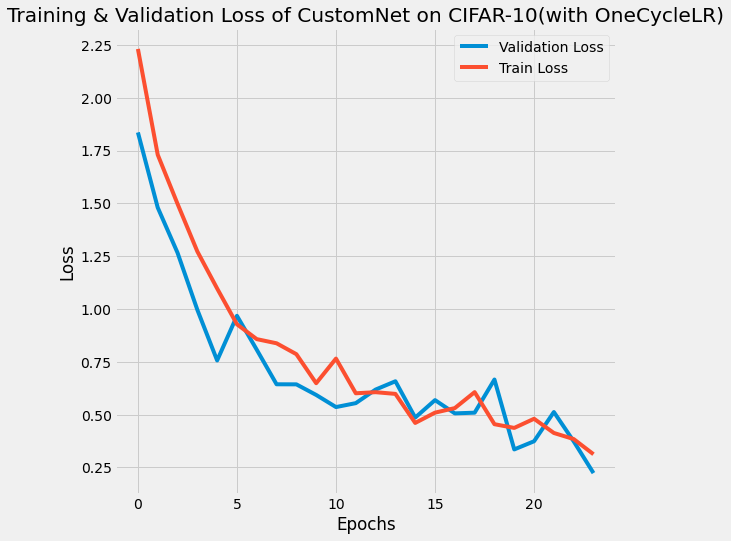

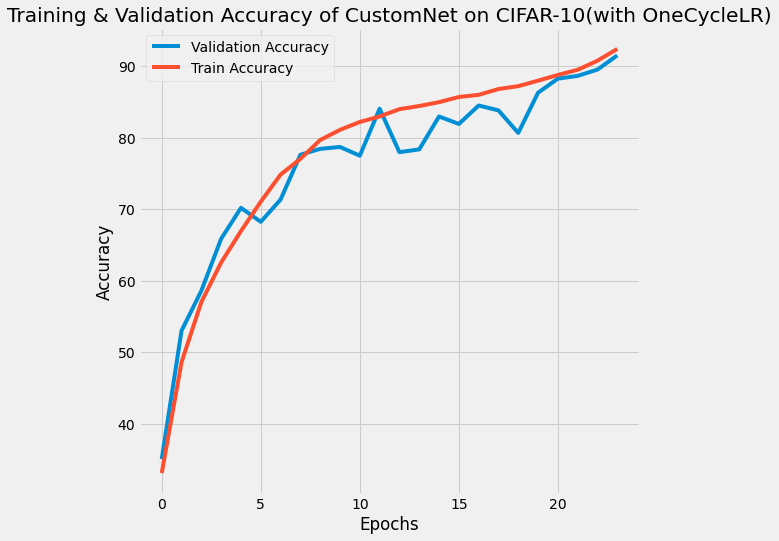

In [20]:
accuracyElements = [(model1.test_acc,"Validation Accuracy"),(model1.train_epoch_end,"Train Accuracy")]
lossElements = [(model1.test_losses,"Validation Loss"),(model1.train_losses,"Train Loss")]

for i in range(1):
  display.plot_curve(lossElements,'Training & Validation Loss of CustomNet on CIFAR-10(with OneCycleLR)', y_label='Loss')
  display.plot_curve(accuracyElements,'Training & Validation Accuracy of CustomNet on CIFAR-10(with OneCycleLR)')


**CLR Plot**

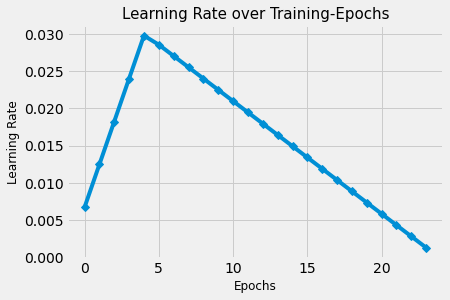

In [18]:
with plt.style.context('fivethirtyeight'):
  plt.plot(learningRates, '-D')
  plt.xlabel('Epochs', fontsize=12)
  plt.ylabel('Learning Rate', fontsize=12)
  plt.title('Learning Rate over Training-Epochs',fontsize=15)

**Misclassified Images**

MessageError: ignored

<Figure size 936x936 with 0 Axes>

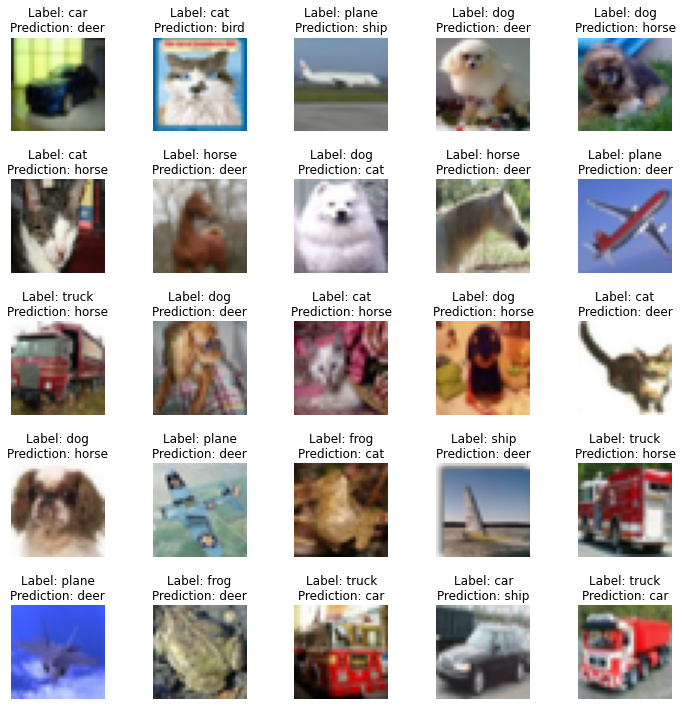

In [19]:
display.misclassified_ones(model, testLoader, incorrectSamples,'MisclassfiedOnes.png')

#GradCam Implementation

**GradCam Input Data**

In [21]:
images = [x['image'] for x in incorrectSamples[20:28]] # Extracting MisClassified Images
target_classes = [l['label'] for l in incorrectSamples[20:28]] # Target Classes
predicted_classes = [p['prediction'] for p in incorrectSamples[20:28]] # Predicted Classes
targetLabels = [classes[t] for t in target_classes] # Target Labels
predLabels = [classes[p] for p in predicted_classes] # Predicted Labels


**GradCam Core** 

IMPLEMENTING GRADCAM...
torch.Size([8, 10])
Generating Grad-CAM @layer1
Generating Grad-CAM @layer2
Generating Grad-CAM @layer3
Generating Grad-CAM @layer4


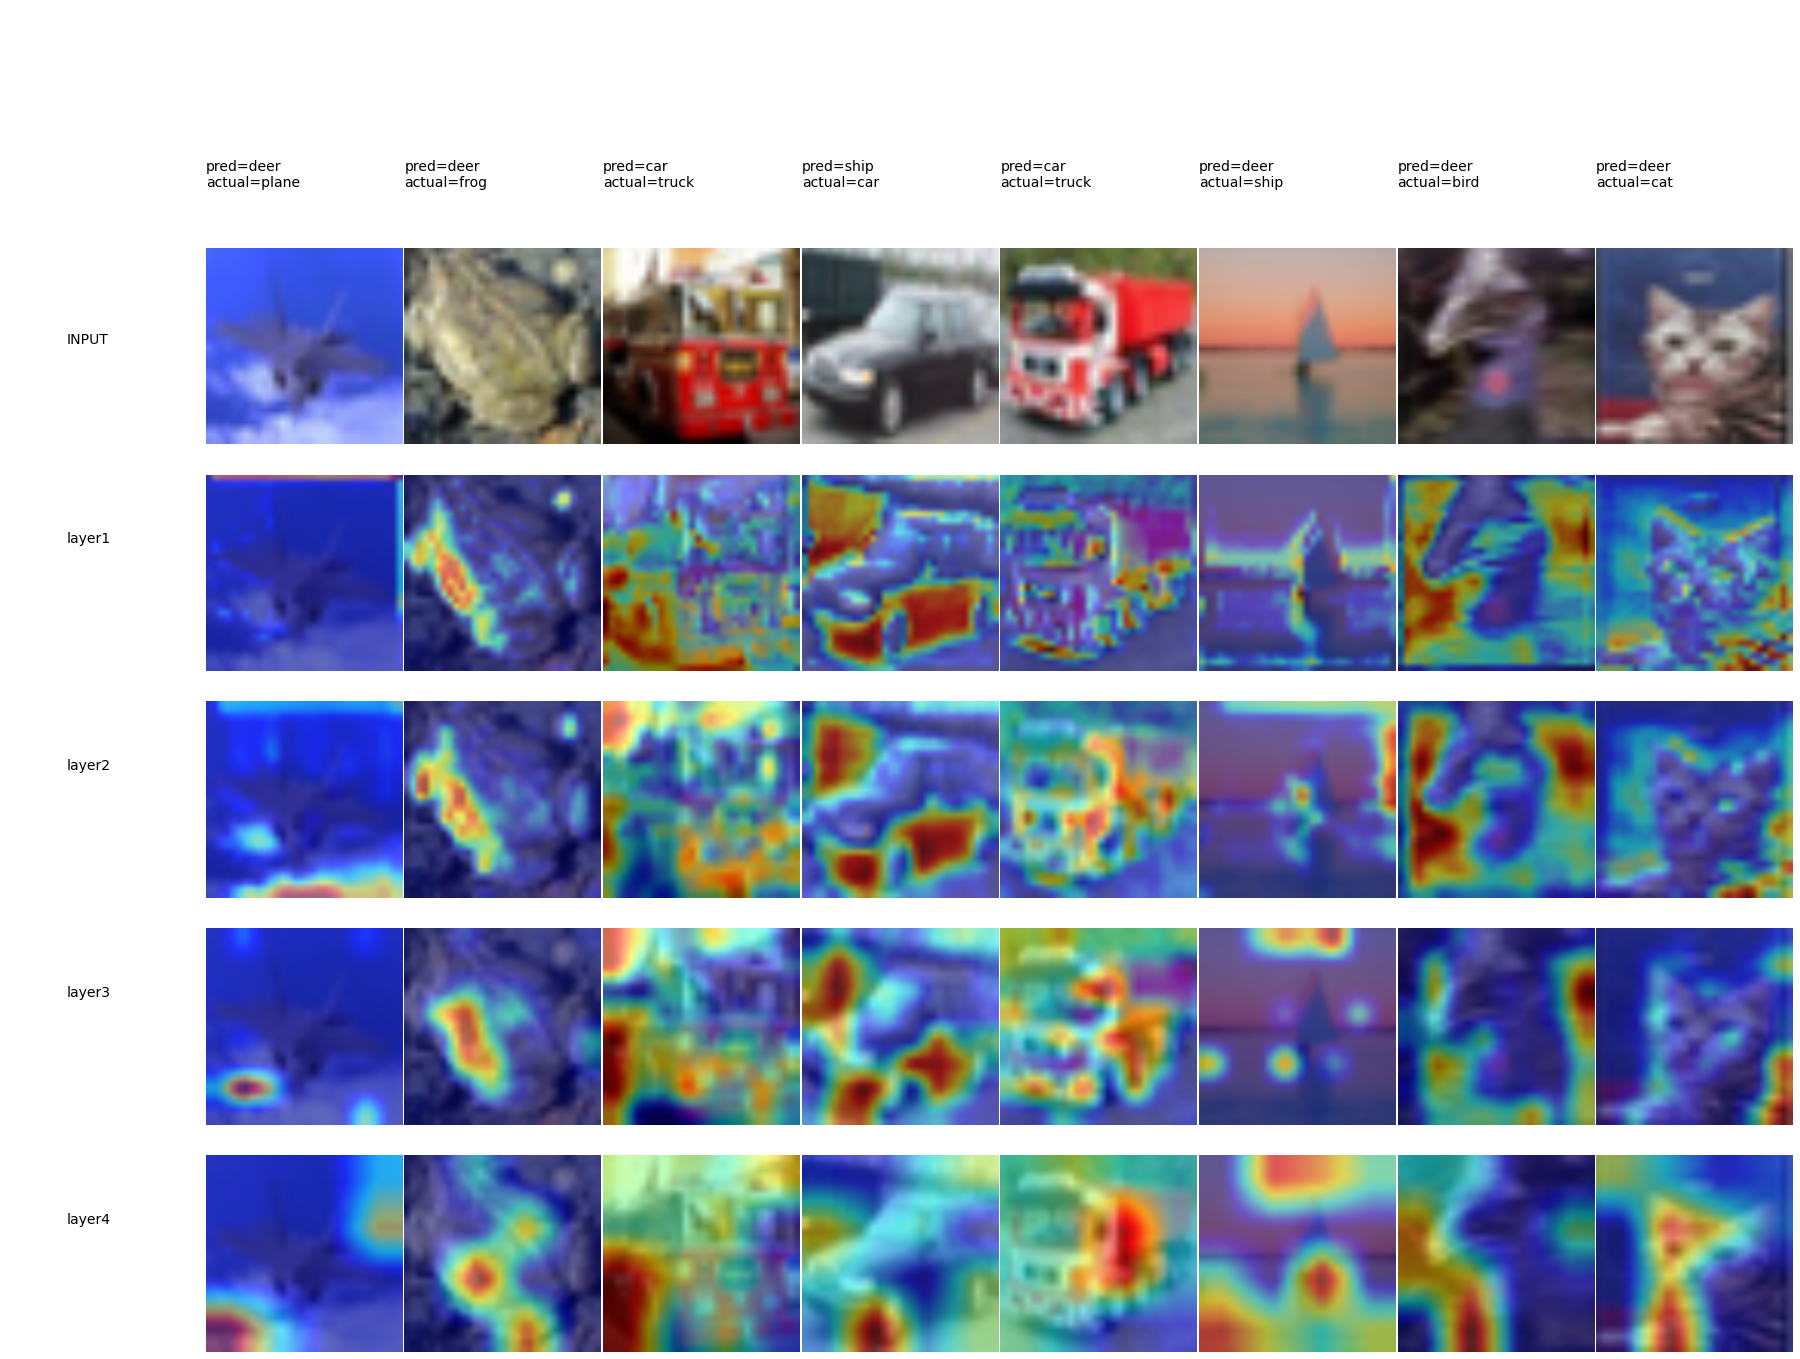

In [22]:
model = ResNet18().to(device)
image_size = (3,32,32) # set image size

target_layers = ["layer1", "layer2", "layer3", "layer4"]
print('IMPLEMENTING GRADCAM...')
gradcam_output, probs, predicted_classes = gdc.GRADCAM(images, device, target_classes, model, target_layers) 
gdc.PLOT(gradcam_output, images, target_layers, image_size, display.unnormalize, targetLabels, predLabels) # Plot the gradcam_output for the target layers
